# Spatial LDA Preprocessing

## Overview and Setup
This notebook walks through the various steps of transforming and evaluating a standard cell table to be compatible with Spatial-LDA analysis.  The main topics covered are:

- [Correctly Formatting a Cell Table](#Correctly-Formatting-a-Cell-Table)
- [Defining Local Cellular Neighborhoods](#Defining-Local-Cellular-Neighborhoods)
- [Calculating Neighborhood Characteristics](#Calculating-Neighborhood-Characteristics)
- [Determining the Number of Topics](#Determining-the-Number-of-Topics)
- [Saving Results](#Saving-Results)

#### Import Required Packages

In [1]:
import os

import pandas as pd

import ark.settings as settings
from ark.analysis import visualize
from ark.spLDA import processing
from ark.utils import example_dataset, spatial_lda_utils

### Download the Example Dataset

Here we are using the example data located in `/data/example_dataset/input_data`. To modify this notebook to run using your own data, simply change the `base_dir` to point to your own sub-directory within the data folder, rather than `'example_dataset'`.

* `base_dir`: the path to all of your imaging data. This directory will contain all of the data generated by this notebook.

In [ ]:
base_dir = "../data/example_dataset"

If you would like to test the features in Ark with an example dataset, run the cell below. It will download a dataset consisting of 11 FOVs with 22 channels. You may find more information about the example dataset in the [README](../README.md#example-dataset).

* `overwrite_existing`: If set to `False`, it will not overwrite existing data in the `data/example_dataset`. Recommended setting it to `True` if you have not run Notebooks 1-3.

In [ ]:
example_dataset.get_example_dataset(dataset="LDA_preprocessing", save_dir=base_dir, overwrite_existing=False)

#### Set Up File Paths
- `base_dir`: working directory
- `cell_table_path`: The path to the Cell Table
- `processed_dir`: destination directory for the processed data
- `viz_dir`: destination directory for all plots and visualizations

In [2]:
cell_table_path = os.path.join(base_dir, "segmentation/cell_table/cell_table_size_normalized_cell_labels.csv")
processed_dir = os.path.join(base_dir, "spatial_analysis/spatial_lda/preprocessed/")
viz_dir = os.path.join(base_dir, "spatial_analysis/spatial_lda/visualization")

# Create directories if they do not exist
for directory in [processed_dir, viz_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

## Correctly Formatting a Cell Table
In order to proceed, you'll need data in the form of a standard cell table similar to the output of __[generate_cell_table()](https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.segmentation.html#ark.segmentation.marker_quantification.generate_cell_table)__.  The cell table should be in `.csv` format.

Assuming the data have undergone pixel clustering, the cell table should contain the following columns in addition to any marker-specific columns:

In [ ]:
print(settings.BASE_COLS)

#### Import and Inspect the Cell Table

In [ ]:
cell_table = pd.read_csv(cell_table_path)
print(cell_table.columns)

In [ ]:
correct_cols = all(col in cell_table.columns for col in settings.BASE_COLS)
print(correct_cols)

Check that the column names in your cell table match those in `settings.BASE_COLS`.  If there are
descrepencies the above cell will output `False` and you will need to change the relevant column names in `rename` below.

In [8]:
if not correct_cols:
    rename = {
        'Your_FOV_column_name' : settings.FOV_ID,
        'Your_centroid_x_coord_column_name': settings.CENTROID_0,
        'Your_centroid_y_coord_column_name': settings.CENTROID_1,
        'Your_cell_cluster_column_name': settings.CELL_TYPE,
        'Your_cell_label_column_name': settings.CELL_LABEL,
    }
    cell_table = cell_table.rename(rename, axis=1)

#### Format the Cell Table
The following code will transform the cell table into a format suitable for Spatial-LDA.  Here is where you can specify which clusters or markers to include in your analysis.  Indicate markers by their column name.

At this stage, you must specify either clusters, markers, or both.  By specifying both fields, you can fit separate models later based on either one.  If you know you do not want to include any markers (or clusters), set `markers = None` (likewise for clusters).


In [9]:
# Specify which markers and clusters to include

# your markers could  be loaded from a panel via
# panel = pd.read_csv(panel_path)
# markers = list(panel['Targets'])

# or you can copy and paste the releavant column names output of cell 4 and trim as needed
markers = ['CD14', 'CD163', 'CD20', 'CD3', 'CD31', 'CD4', 'CD45',
           'CD68', 'CD8', 'CK17', 'Collagen1', 'ECAD', 'Fibronectin', 'GLUT1',
           'H3K27me3', 'H3K9ac', 'HLADR', 'IDO', 'Ki67', 'PD1', 'SMA', 'Vim',
           ]

# use all clusters
clusters = list(cell_table.cell_meta_cluster.unique())

# or use manually specified cluster names
# clusters = ['CD4_T', 'CD8_T', ...]

In [10]:
# Call formatting function
formatted_cell_table = processing.format_cell_table(
    cell_table=cell_table, markers=markers, clusters=clusters)

The result is now a dictionary with one element per field of view (FOV) which contains only the necessary columns for spatial-LDA.

## Defining Local Cellular Neighborhoods
Spatial-LDA tries to learn information about cells in similar "neighborhoods".  To do that, we need to define the size and location of each neighborhood.

Determining a reasonable neighborhood size around a particular cell will depend on the size and quantity of all cells in the FOV, but a typical size is a radius between 100-200 pixels.  The neighborhood around that cell then includes all cells whose centroid falls within the provided radius.

The code below collects metrics regarding the distribution of cell counts and cell size among all FOVs.  If the pixel dimension of your FOVs is anything other than 1,024 x 1,024 then indicate it using the `total_pix` argument.

In [11]:
fov_stats = processing.fov_density(
    cell_table=formatted_cell_table, total_pix=1024 ** 2)

The output contains three metrics per FOV:
- `average_area`: average cell size (in pixel area)
- `cellular_density`: ratio of total pixels occupied by cells to total pixels
- `total_cells`: total number of individual cells

These metrics can be visualized below.

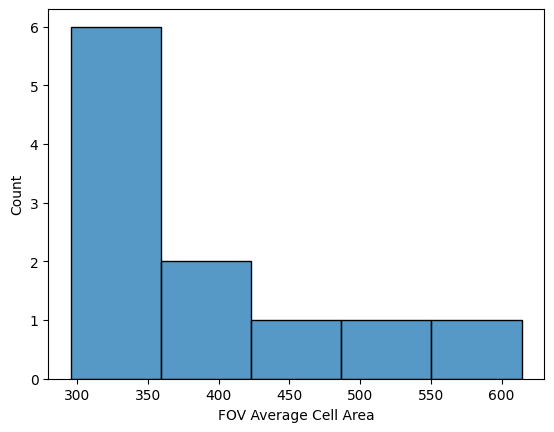

In [12]:
# Average area
visualize.visualize_fov_stats(
    fov_stats, metric="average_area", save_dir=viz_dir)

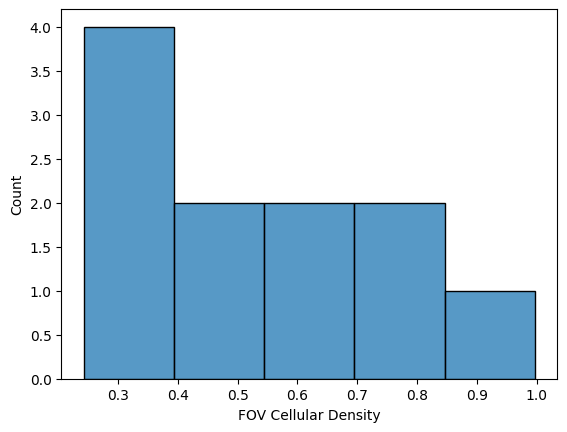

In [13]:
# Cellular density
visualize.visualize_fov_stats(
    fov_stats, metric="cellular_density", save_dir=viz_dir)

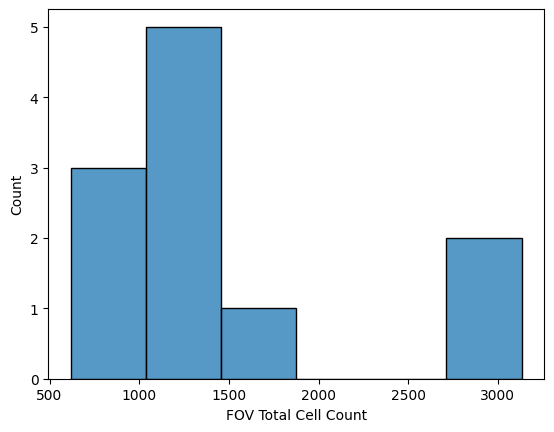

In [14]:
# Total cells
visualize.visualize_fov_stats(
    fov_stats, metric="total_cells", save_dir=viz_dir)

#### Neighborhood Size
If a large number of FOVs have low cell counts, then defining a larger neighborhood size in the next section may be warranted.  On the other hand, if many of the FOVs are densely packed with cells then a smaller neighborhood size will likely perform better.

## Calculating Neighborhood Characteristics
The next steps combine the radius information learned above with marker or cluster data to construct cellular neighborhoods and measure adjacent cells.

#### Featurize the Cell Table
In this step, the neighborhood around each index cell is summarized using one of four featurization methods.  The four methods are `cluster`, `marker`, `avg_marker`, and `count`.  For specific details about each method, see the [documentation](__https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.spLDA.html#ark.spLDA.processing.featurize_cell_table__) of `featurize_cell_table()`.

By default, all cells are labelled as index cells, but you can choose to only use specific cells if desired.  If so, you must create a new column to indicate which cells are index cells.  Below is an example of code that would create an index column for tumor cells:

In [15]:
# Example: create custom index column for tumor cells

for i in formatted_cell_table["fovs"]:
    is_tumor = formatted_cell_table[i]["cluster"] == "tumor_ck17"
    formatted_cell_table[i]["is_tumor"] = is_tumor

In [16]:
# Set featurization parameters
featurization = "cluster"
radius = 200
cell_index = "is_index"

In [17]:
# Call featurization function
featurized_cell_table = processing.featurize_cell_table(
    cell_table=formatted_cell_table, featurization=featurization,
    radius=radius, cell_index=cell_index, n_processes=4)

  0%|          | 0/11 [00:00<?, ?it/s]

In addition to summarizing the cellular neighborhoods, `featurize_cell_table()` will also set aside a fraction of the data to use as a training set.

#### Constructing the Adjacency Network
The following code computes pairwise distances between cells and uses this information to build a network graph of adjacent cells.  Cells are considered adjacent if they share a facet in the Voronoi partitioning of cell positions.  Spatial-LDA uses this information to regulate how likely adjacent cells are to have similar topic preferences.

In [18]:
difference_mats = processing.create_difference_matrices(
    cell_table=formatted_cell_table, features=featurized_cell_table)

In [19]:
disp_fovs = list(formatted_cell_table.keys())[:2]

The output contains the difference matrices for the training data and also the full combined data.  The adjacency network graph of the training data can be visualized for each FOV which can help give you an idea of how sparsely populated a particular FOV may be.

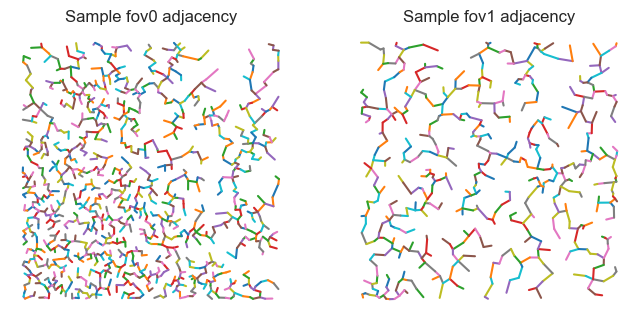

In [20]:
visualize.visualize_fov_graphs(
    cell_table=formatted_cell_table, features=featurized_cell_table,
    diff_mats=difference_mats, fovs=disp_fovs, save_dir=viz_dir)

## Determining the Number of Topics
Training a spatial-LDA model can be computationally expensive, so it's worth exploring some reasonable values of topic parameters before running the algorithm.

Five different metrics are currently supported for evaluating a K-means clustering of the featurized cell table where the number of K-means clusters is a proxy for the number of topics.  The five different metrics are `inertia`, `silhouette`, `gap_stat`, `percent_var_exp`, and `cell_counts`.

For details about each metric, see the [documentation](__https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.spLDA.html#ark.spLDA.processing.compute_topic_eda__) for `compute_topic_eda()`.

#### Computing EDA Metrics
The code block below allows you to specify different number of topics to explore using all five metrics.

In [23]:
# specify different topic numbers and bootstrap iterations
num_topics = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
num_boots = None

In [24]:
topic_eda = processing.compute_topic_eda(
    features=featurized_cell_table["featurized_fovs"],
    featurization=featurized_cell_table["featurization"],
    topics=num_topics,
    num_boots=num_boots)

  0%|          | 0/18 [00:00<?]

#### Visualizing EDA Metrics

The following code blocks produce plots of each metric as a function of the number of clusters (topics).

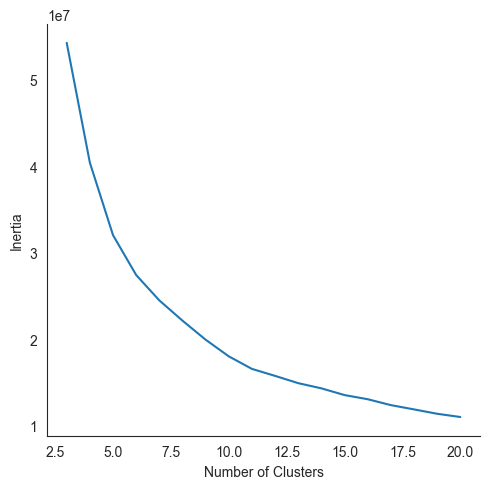

In [25]:
# Inertia
visualize.visualize_topic_eda(
    data=topic_eda, metric="inertia", save_dir=viz_dir)

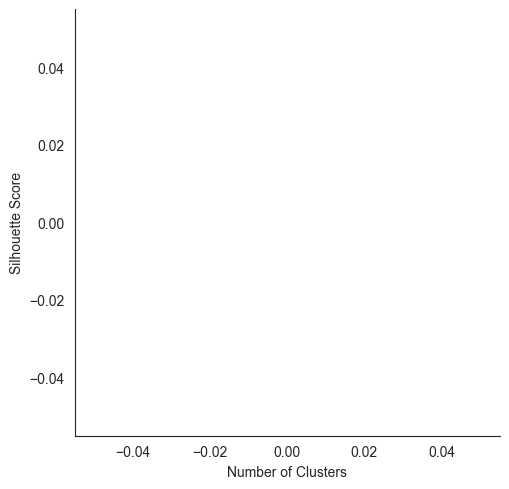

In [26]:
# Silhouette Score
visualize.visualize_topic_eda(
    data=topic_eda, metric="silhouette", save_dir=viz_dir)

In [27]:
# Gap Statistic
if num_boots is not None:
    visualize.visualize_topic_eda(
        data=topic_eda, metric="gap_stat", save_dir=viz_dir)

The code below plots a heatmap of the cell features against the specific cluster assignments from a given K-means clustering.  You must specify one value of `k` present in the `num_topics` variable above.

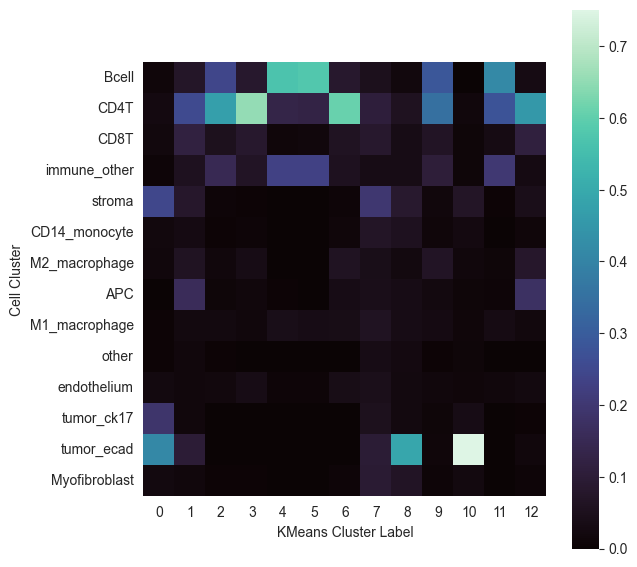

In [29]:
# Cell Feature Distribution
k=num_topics[10]
visualize.visualize_topic_eda(
    data=topic_eda, metric="cell_counts", k=k, save_dir=viz_dir)

## Saving Results
The plots and figures above will be saved in the directory specified by `viz_dir` if it was passed to the visualization functions.  To save the formatted and/or featurized cell tables along with the difference matrices, use the code block below.

*Note: entire dictionary objects can be saved into .pkl files.  If you want to save data frames for specific FOVs individually as .csv files, you need to extract the desired data frame and specify format="csv" in the saving function.*

In [30]:
# save formatted cell table
file_name = "formatted_cell_table"
spatial_lda_utils.save_spatial_lda_file(
    data=formatted_cell_table, dir=processed_dir, file_name=file_name, format="pkl")

In [31]:
# save featurized cell table
file_name = "featurized_cell_table"
spatial_lda_utils.save_spatial_lda_file(
    data=featurized_cell_table, dir=processed_dir, file_name=file_name, format="pkl")

In [32]:
# save difference matrices
file_name = "difference_mats"
spatial_lda_utils.save_spatial_lda_file(
    data=difference_mats, dir=processed_dir, file_name=file_name, format="pkl")

In [33]:
# save FOV stats
file_name = "fov_stats"
spatial_lda_utils.save_spatial_lda_file(
    data=fov_stats, dir=processed_dir, file_name=file_name, format="pkl")

In [34]:
# save topic EDA
file_name = "topic_eda"
spatial_lda_utils.save_spatial_lda_file(
    data=topic_eda, dir=processed_dir, file_name=file_name, format="pkl")